In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.express as px

# 0. Load data

In [2]:
# Open the Pickle file in binary mode for reading
with open('../data/car_data.pickle', 'rb') as file:
    # Load the Pickle file
    res_list = pickle.load(file)

In [3]:
basic_car_parameters = [x[0] for x in res_list]
missing_values = pd.Series([x[0] is None for x in res_list])
special_car_parameters = pd.Series([x[1] for x in res_list])[~missing_values]
link = pd.Series([x[2] for x in res_list])[~missing_values]


In [4]:
np.sum(missing_values)

235

In [5]:
df_basics = pd.concat(basic_car_parameters)
df_basics.head()

,Vételár:,Vételár EUR:,Évjárat:,Állapot:,Kivitel:,Járműelőélet:,Finanszírozás:,Km. óra állás:,Szállítható szem. száma:,Ajtók száma:,...,Finanszírozás típusa CASCO-val:,Finanszírozás típusa CASCO nélkül:,Garancia:,Szavatossági garancia:,Alaptípus ára:,Futásidő:,Átrozsdásodási garancia:,Kezdőrészlet CASCO nélkül:,Havi részlet CASCO nélkül:,Futamidő CASCO nélkül:
1,6 895 000 Ft,€ 18 154,2016/3,Kitűnő,Sedan,Elérhető autó-előélet alvázszám alapján,25%-tól elvihető,110 000 km,5 fő,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9 999 999 Ft,€ 25 813,2014/11,Megkímélt,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,20%-tól elvihető,119 300 km,5 fő,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4 995 000 Ft,€ 13 152,2018/8,Kitűnő,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,20%-tól elvihető,70 000 km,5 fő,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3 499 000 Ft,€ 9 032,2016/12,Kitűnő,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,NaN,100 000 km,5 fő,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7 990 000 Ft,€ 20 625,2018/1,Normál,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,20%-tól elvihető,74 760 km,5 fő,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Data cleaning

## 1.1 Clean basic dataset

Basic dataset contains the features that are written in a structured from for every car. Other information will be handled later

### 1.1.1 Clean the target variable

In [7]:
df_basics2 = df_basics.copy().reset_index(drop=True)
# Some car has only EUR price
msk_eur_price = (df_basics['Vételár:'] == df_basics['Vételár EUR:']).values

# Convert column namas to lower case and remove :
df_basics2.columns = df_basics2.columns.str.lower().str.replace(':', '')

# Add link to the dataset
df_basics2['link'] = link.values

# Convert price to numberic and remove eur (since it is duplication)
df_basics2['vételár'] = df_basics2['vételár'].str.replace(r'\D', '', regex=True)
df_basics2['akciós ár'] = df_basics2['akciós ár'].str.replace(r'\D', '', regex=True)
df_basics2['extrákkal növelt ár'] = df_basics2['extrákkal növelt ár'].str.replace(r'\D', '', regex=True)

# If price is missing use discound price
price_is_nan = df_basics2['vételár'].isna()
df_basics2.loc[price_is_nan, 'vételár'] = df_basics2.loc[price_is_nan, 'akciós ár'].values

# If price still missing use extra chage price
price_is_nan = df_basics2['vételár'].isna()
df_basics2.loc[price_is_nan, 'vételár'] = df_basics2.loc[price_is_nan, 'extrákkal növelt ár'].values

# There are 2 cars without price 
# -» replace value with -1 and hadle it later, 
# not drop yet since special values will be concated 
df_basics2.loc[df_basics2['vételár'] == '', 'vételár'] = -1
df_basics2.loc[df_basics2['vételár'].isna(), 'vételár'] = -1

# Remove EUR
df_basics2.drop(columns=['vételár eur'], inplace=True)


# Convert vételar to int
df_basics2['vételár'] = df_basics2['vételár'].astype(int)
df_basics2.loc[msk_eur_price, 'vételár'] *= 375 # Convert eur to huf by muliplying it with the euro exchange rate

df_basics2['akciós ár'] = df_basics2['akciós ár'].astype(float)
df_basics2['extrákkal növelt ár'] = df_basics2['extrákkal növelt ár'].astype(float)

df_basics2.head()

,vételár,évjárat,állapot,kivitel,járműelőélet,finanszírozás,km. óra állás,szállítható szem. száma,ajtók száma,szín,...,finanszírozás típusa casco nélkül,garancia,szavatossági garancia,alaptípus ára,futásidő,átrozsdásodási garancia,kezdőrészlet casco nélkül,havi részlet casco nélkül,futamidő casco nélkül,link
0,6895000,2016/3,Kitűnő,Sedan,Elérhető autó-előélet alvázszám alapján,25%-tól elvihető,110 000 km,5 fő,4,Fekete (metál),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.hasznaltauto.hu/szemelyauto/volksw...
1,9999999,2014/11,Megkímélt,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,20%-tól elvihető,119 300 km,5 fő,5,Fehér,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.hasznaltauto.hu/szemelyauto/merced...
2,4995000,2018/8,Kitűnő,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,20%-tól elvihető,70 000 km,5 fő,5,Kék,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.hasznaltauto.hu/szemelyauto/dacia/...
3,3499000,2016/12,Kitűnő,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,NaN,100 000 km,5 fő,5,Sötétkék,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.hasznaltauto.hu/szemelyauto/renaul...
4,7990000,2018/1,Normál,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,20%-tól elvihető,74 760 km,5 fő,5,Fehér,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.hasznaltauto.hu/szemelyauto/merced...


### 1.1.2 Handel NaN Value

In [8]:
dataset_size = len(df_basics2)

In [11]:
# NaN count
nan_count = df_basics2.isna().sum()
nan_count

0
vételár                        0
évjárat                        0
állapot                        0
kivitel                        0
járműelőélet                   0
finanszírozás              26447
km. óra állás                  0
szállítható szem. száma     1502
ajtók száma                 1454
szín                        4752
saját tömeg                 3888
teljes tömeg                4219
csomagtartó                 7489
klíma fajtája               3999
tető                       24521
üzemanyag                    414
hengerűrtartalom            2530
teljesítmény                 969
henger-elrendezés           8571
hajtás                      2087
sebességváltó               1412
okmányok jellege              26
műszaki vizsga érvényes     4394
nyári gumi méret            8592
buy_from_shop                  0
content_info_0                 0
content_info_1                 0
content_info_2                 0
content_info_3             14770
content_info_4             18912
content_

In [12]:
# Drop columns with less than 1000 not NaN values
high_nan_cols = nan_count[nan_count>dataset_size-1000].keys()
df_basics2.drop(columns=high_nan_cols, inplace=True)

In [13]:
# Check the uumber of unique values
{x:len(df_basics2[x].unique()) for x in df_basics2.columns}

{'vételár': 4117,
 'évjárat': 714,
 'állapot': 5,
 'kivitel': 15,
 'járműelőélet': 1,
 'finanszírozás': 11,
 'km. óra állás': 17290,
 'szállítható szem. száma': 12,
 'ajtók száma': 5,
 'szín': 74,
 'saját tömeg': 1466,
 'teljes tömeg': 997,
 'csomagtartó': 605,
 'klíma fajtája': 7,
 'tető': 13,
 'üzemanyag': 13,
 'hengerűrtartalom': 717,
 'teljesítmény': 367,
 'henger-elrendezés': 8,
 'hajtás': 6,
 'sebességváltó': 48,
 'okmányok jellege': 8,
 'műszaki vizsga érvényes': 109,
 'nyári gumi méret': 456,
 'buy_from_shop': 2,
 'content_info_0': 4273,
 'content_info_1': 1419,
 'content_info_2': 15049,
 'content_info_3': 4375,
 'content_info_4': 3594,
 'content_info_5': 6054,
 'hátsó nyári gumi méret': 324,
 'kárpit színe (1)': 34,
 'kárpit színe (2)': 34,
 'content_info_6': 7212,
 'kezdőrészlet': 489,
 'futamidő': 20,
 'téli gumi méret': 302,
 'hátsó téli gumi méret': 219,
 'link': 35174}

### 1.1.3 Clean the numeric featres

In [14]:
df_basics2.columns

Index(['vételár', 'évjárat', 'állapot', 'kivitel', 'járműelőélet',
       'finanszírozás', 'km. óra állás', 'szállítható szem. száma',
       'ajtók száma', 'szín', 'saját tömeg', 'teljes tömeg', 'csomagtartó',
       'klíma fajtája', 'tető', 'üzemanyag', 'hengerűrtartalom',
       'teljesítmény', 'henger-elrendezés', 'hajtás', 'sebességváltó',
       'okmányok jellege', 'műszaki vizsga érvényes', 'nyári gumi méret',
       'buy_from_shop', 'content_info_0', 'content_info_1', 'content_info_2',
       'content_info_3', 'content_info_4', 'content_info_5',
       'hátsó nyári gumi méret', 'kárpit színe (1)', 'kárpit színe (2)',
       'content_info_6', 'kezdőrészlet', 'futamidő', 'téli gumi méret',
       'hátsó téli gumi méret', 'link'],
      dtype='object', name=0)

In [54]:
# Simple conversions 
# Convert done km to int
df_basics2['km. óra állás'] = df_basics2['km. óra állás'].str.replace(r'\D', '', regex=True).astype(int)

# Convert max passenger count to flaot (not int since it contains NaNs)
df_basics2['szállítható szem. száma'] = df_basics2['szállítható szem. száma'].str.replace(r'\D', '', regex=True).astype(float)

# Convert the number of doors to flaot (not int since it contains NaNs)
df_basics2['ajtók száma'] = df_basics2['ajtók száma'].str.replace(r'\D', '', regex=True).astype(float)


# Convert own and total weight to flaot
df_basics2['saját tömeg'] = df_basics2['saját tömeg'].str.replace(r'\D', '', regex=True).astype(float)
df_basics2['teljes tömeg'] = df_basics2['teljes tömeg'].str.replace(r'\D', '', regex=True).astype(float)

# Convert trunk volume to numeric 
df_basics2['csomagtartó'] = df_basics2['csomagtartó'].str.replace(r'\D', '', regex=True).astype(float)

# Convert cylinder capacity to numeric
df_basics2['hengerűrtartalom'] = df_basics2['hengerűrtartalom'].str.replace(r'\D', '', regex=True).astype(float)

# Initial installment
df_basics2['kezdőrészlet'] = df_basics2['kezdőrészlet'].str.replace(r'\D', '', regex=True).astype(float)

# Term 
df_basics2['futamidő'] = df_basics2['futamidő'].str.replace(r'[^a-zA-Z]', '', regex=True)

In [33]:
p1 = df_basics2['teljesítmény'].str.replace(r'kW.*', '', regex=True).str.replace(r'\D', '', regex=True).astype(float)

In [34]:
p2 = df_basics2['teljesítmény'].str.replace(r'.*?(\d+).LE', r'\1', regex=True).astype(float)

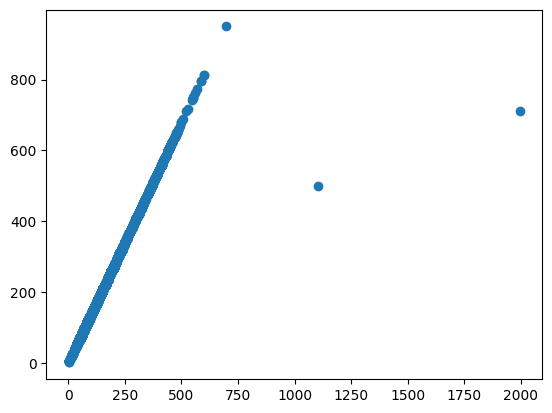

In [35]:
plt.scatter(x=p1, y=p2)

In [55]:
# Convert creation date to age
df_basics2['évjárat'] = pd.to_datetime(df_basics2['évjárat'].str.replace(r'\(.+\)', '', regex=True)) # there are some datewith comments like 1986/6 (30 évnél öregebb)
df_basics2['age_days'] = (pd.to_datetime('2023-06') - df_basics2['évjárat']).astype('timedelta64[D]')

# Convert performance to numeric. Use only the kW unit
df_basics2['teljesítmény'] = df_basics2['teljesítmény'].str.replace(r'kW.*', '', regex=True).str.replace(r'\D', '', regex=True).astype(float)

# Convert technical license validity date
# Some of the date time invalid can't be converted (like '/7', '10' ...)
df_basics2['műszaki vizsga érvényes'] = np.where(
    df_basics2['műszaki vizsga érvényes'].str.contains(r'^/', regex=True)==True,
    np.nan, # Replace invalid values with NaN
    df_basics2['műszaki vizsga érvényes']
)

df_basics2['műszaki vizsga érvényes'] = (pd.to_datetime(df_basics2['műszaki vizsga érvényes'])-pd.to_datetime('2023-06')).astype('timedelta64[D]')


# Extract car summer and winter back and front tire data
pattern = '(?P<Width>\d+)/(?P<AspectRatio>\d+)\s(?P<ConstructionType>[A-Z])\s(?P<RimDiameter>\d+)'

df_basics2[['summer tire width', 'summer tires apect ratio', 'summer tires construction type', 'summer tires rim diameter']] = df_basics2['nyári gumi méret'].str.extract(pattern)
df_basics2[['winter tire width', 'winter tires apect ratio', 'winter tires construction type', 'winter tires rim diameter']] = df_basics2['téli gumi méret'].str.extract(pattern)
df_basics2[['back summer tire width', 'back summer tires apect ratio', 'back summer tires construction type', 'back summer tires rim diameter']] = df_basics2['hátsó nyári gumi méret'].str.extract(pattern)
df_basics2[['back winter tire width', 'back winter tires apect ratio', 'back winter tires construction type', 'back winter tires rim diameter']] = df_basics2['hátsó téli gumi méret'].str.extract(pattern)

numeric_values_from_extractions = [
    'summer tire width', 'summer tires apect ratio', 'summer tires rim diameter',
    'winter tire width', 'winter tires apect ratio', 'winter tires rim diameter',
    'back summer tire width', 'back summer tires apect ratio', 'back summer tires rim diameter',
    'back winter tire width', 'back winter tires apect ratio', 'back winter tires rim diameter'
]
df_basics2[numeric_values_from_extractions] = df_basics2[numeric_values_from_extractions].astype(float)


## 2.1 Clean car specific information

In [56]:
def extract_detailed_descriptions(special_car_parameters):
    without_descrioption = []
    descriptions = []
    for x in special_car_parameters:
        if len(x) > 0:
            msk = x.str.contains('leírás')
            if np.any(msk):
                without_descrioption.append(x[~msk])
                descriptions.append(x[msk].values[0])
            else:
                without_descrioption.append(x)
                descriptions.append(np.nan)
        else:
            without_descrioption.append(pd.Series(['']))
            descriptions.append(np.nan)            
    
    return without_descrioption, descriptions


without_descrioption, descriptions = extract_detailed_descriptions(special_car_parameters)

In [57]:
all_special_features = pd.concat(without_descrioption)
special_frequency = all_special_features.value_counts()
usable_features = special_frequency[special_frequency > 1000].keys()

In [58]:
# Handle number of speakers
speaker_count = [4, 6, 8, 10, 12]

def check_speker_count(car_special_features):
    for sc in speaker_count:
        if np.any(car_special_features == f"{sc} hangszóró"):
            return sc
    
    return np.nan
    
df_special = pd.DataFrame([check_speker_count(x) for x in without_descrioption], columns=['speaker count'])
df_special.head()

,speaker count
0,8.0
1,NaN
2,6.0
3,6.0
4,NaN


In [59]:
# Remove speaker info and empty values and header vlaues on the webpage
usable_features = usable_features[~usable_features.isin(
    list(pd.Series(speaker_count).astype(str)+' hangszóró')+
    ['', 'kültér', 'műszaki','beltér', 'multimédia / navigáció', 'egyéb információ']
)]


In [60]:
for fearture in usable_features:
    df_special[fearture] = [np.any(x == fearture) for x in without_descrioption]

/var/folders/6p/rn1y8jlj4q5fp4y6jrn3qslc0000gn/T/ipykernel_97676/3479662729.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_special[fearture] = [np.any(x == fearture) for x in without_descrioption]
/var/folders/6p/rn1y8jlj4q5fp4y6jrn3qslc0000gn/T/ipykernel_97676/3479662729.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_special[fearture] = [np.any(x == fearture) for x in without_descrioption]
/var/folders/6p/rn1y8jlj4q5fp4y6jrn3qslc0000gn/T/ipykernel_97676/3479662729.py:2: PerformanceWarning: DataFrame is highly fr

# 3. Check the total dataset

In [62]:
df_total = pd.concat([df_basics2, df_special], axis = 1)

# Add description
df_total['description'] = descriptions

# Now we can handle the 2 missing values
df_total = df_total[df_total['vételár'] != -1]

# Drop cols were extracted
df_total.drop(
    columns=['nyári gumi méret', 'hátsó nyári gumi méret', 'téli gumi méret', 'hátsó téli gumi méret', 'évjárat'], 
    inplace=True
)

n1 = len(df_total)
# Drop duplicates
df_total = df_total.drop_duplicates(subset='link').reset_index(drop=True)
n2 = len(df_total)
if n1 != n2:
    print('Duplicated links:', n2-n1)

df_total.head()

/var/folders/6p/rn1y8jlj4q5fp4y6jrn3qslc0000gn/T/ipykernel_97676/1391670387.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_total['description'] = descriptions
/var/folders/6p/rn1y8jlj4q5fp4y6jrn3qslc0000gn/T/ipykernel_97676/1391670387.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total.drop(


,vételár,állapot,kivitel,járműelőélet,finanszírozás,km. óra állás,szállítható szem. száma,ajtók száma,szín,saját tömeg,...,25%-tól elvihető,gyalogos légzsák,elektromosan állítható fejtámlák,otthoni hálózati töltő,rablásgátló,vonóhorog - elektromosan kihajtható,erősítő,velúr kárpit,type2 töltőkábel,description
0,6895000,Kitűnő,Sedan,Elérhető autó-előélet alvázszám alapján,25%-tól elvihető,110000,5.0,4.0,Fekete (metál),1426.0,...,True,False,False,False,False,False,False,False,False,leírás\nelső tulajdonostól érkezett hozzánk ez...
1,9999999,Megkímélt,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,20%-tól elvihető,119300,5.0,5.0,Fehér,2150.0,...,False,False,False,False,True,False,False,False,False,"leírás\nszép állapotú, 119 300 kilométert futo..."
2,4995000,Kitűnő,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,20%-tól elvihető,70000,5.0,5.0,Kék,1200.0,...,False,False,False,False,False,False,False,False,False,leírás\nelső tulajdonostól érkezett hozzánk! t...
3,3499000,Kitűnő,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,NaN,100000,5.0,5.0,Sötétkék,1176.0,...,False,False,False,False,False,False,False,False,False,"leírás\neladó egy új korában magyarországon, a..."
4,7990000,Normál,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,20%-tól elvihető,74760,5.0,5.0,Fehér,1470.0,...,False,False,False,False,False,False,False,False,False,NaN


In [63]:
# Categorical nan to ''
# This is neccessary for carboost regression
# Numeric nan is handled by the model
dtypes = df_total.dtypes
cat_cols = dtypes[dtypes == object].keys()
df_total[cat_cols] = df_total[cat_cols].fillna('')

In [64]:
column_names = df_total.columns

In [65]:
rename_dict = {
    'vételár': 'price (HUF)',
    'állapot': 'condition',
    'kivitel': 'design',
    'járműelőélet': 'vehicle history',
    'finanszírozás': 'financing',
    'km. óra állás': 'clock position (km)',
    'szállítható szem. száma': 'shippable persons number',
    'ajtók száma': 'number of doors',
    'szín': 'color',
    'saját tömeg': 'own weight (kg)',
    'teljes tömeg': 'total weight (kg)',
    'csomagtartó': 'trunk (l)',
    'klíma fajtája': 'type of climate',
    'tető': 'roof',
    'üzemanyag': 'fuel',
    'hengerűrtartalom': 'cylinder capacity (cm3)',
    'teljesítmény': 'performance (kW)',
    'henger-elrendezés': 'cylinder arrangement',
    'hajtás': 'drive',
    'sebességváltó': 'gearbox',
    'okmányok jellege': 'nature of documents',
    'műszaki vizsga érvényes': 'MOT is valid (days)',
    'kárpit színe (1)': 'upholstery color (1)',
    'kárpit színe (2)': 'upholstery color (2)',
    'kezdőrészlet': 'initial part',
    'futamidő': 'term',
    'elektromos ablak elöl': 'electric window in front',
    'vezetőoldali légzsák': 'abs (anti-lock braking)',
    'abs (blokkolásgátló)': 'driver airbag',
    'utasoldali légzsák': 'passenger airbag',
    'elektromos tükör': 'electric mirror',
    'centrálzár': 'central locking',
    'állítható kormány': 'predictable government',
    'oldallégzsák': 'side airbag',
    'ülésmagasság állítás': 'seat height adjustment',
    'szervokormány': 'power steering',
    'könnyűfém felni': 'esp (speed stabilizer)',
    'esp (menetstabilizátor)': 'alloy wheels',
    'elektromos ablak hátul': 'electric rear window',
    'asr (kipörgésgátló)': 'asr (traction control)',
    'fedélzeti komputer': 'board computer',
    'fűthető tükör': 'heatable mirror',
    'isofix rendszer': 'isofix system',
    'hátsó fejtámlák': 'rear head restraints',
    'indításgátló (immobiliser)': 'immobiliser',
    'rendszeresen karbantartott': 'regularly maintained',
    'színezett üveg': 'stained glass',
    'függönylégzsák': 'curtain airbag',
    'tempomat': 'cruise control',
    'ködlámpa': 'fog lamp',
    'középső kartámasz': 'middle armrest',
    'nem dohányzó': 'non-smoking',
    'multifunkciós kormánykerék': 'multifunction steering wheel',
    'garantált km futás': 'guaranteed mileage',
    'bőrkormány': 'leather steering wheel',
    'azonnal elvihető': 'immediately available',
    'tolatóradar': 'reverse radar',
    'bluetooth-os kihangosító': 'bluetooth speakerphone',
    'kikapcsolható légzsák': 'disabled airbag',
    '2 din': '2 din',
    '20%-tól elvihető': 'Take away from 20%',
    '230v csatlakozó hátul': '230v socket at the back',
    '30%-tól elvihető': 'Can be taken away from 30%',
    '360 fokos kamerarendszer': '360 degree camera system',
    'ads (adaptív lengéscsillapító)': 'ads (adaptive shock absorber)',
    'alcantara kárpit': 'alcantara upholstery',
    'android auto': 'android auto',
    'apple carplay': 'apple carplay',
    'ard (automatikus távolságtartó)': 'ard (automatic spacer)',
    'automata fényszórókapcsolás': 'automatic headlight switching',
    'automata távfény': 'automatic high beam',
    'automatikus segélyhívó': 'automatic emergency call',
    'automatikusan sötétedő belső tükör': 'automatically dimming interior mirror',
    'automatikusan sötétedő külső tükör': 'automatically dimming exterior mirror',
    'autóbeszámítás lehetséges': 'car offsetting is possible',
    'autótelefon': 'car phone',
    'aux csatlakozó': 'aux connector',
    'bekanyarodási segédfény': 'turning light',
    'bi-xenon fényszóró': 'bi-xenon headlight',
    'bőr belső': 'leather interior',
    'bőr-szövet huzat': 'skin-fabric cover',
    'cd-s autórádió': 'cd car radio',
    'csomag rögzítő': 'package fixer',
    'defektjavító készlet': 'defect repair kit',
    'defekttűrő abroncsok': 'flat tires',
    'deréktámasz': 'lumbar support',
    'digitális műszeregység': 'digital instrument unit',
    'dvd': 'DVD',
    'dönthető utasülések': 'reclinable passenger seats',
    'ebd/ebv (elektronikus fékerő-elosztó)': 'ebd/ebv (electronic brake force distribution)',
    'edc (elektronikus lengéscsillapítás vezérlés)': 'edc (electronic damping control)',
    'eds (elektronikus differenciálzár)': 'eds (electronic differential lock)',
    'elektromos csomagtérajtó-mozgatás': 'electric tailgate movement',
    'elektromos ülésállítás utasoldal': 'electric seat adjustment passenger side',
    'elektromos ülésállítás vezetőoldal': 'electric seat adjustment driver side',
    'elektromosan behajtható külső tükrök': 'electrically folding exterior mirrors',
    'elektronikus futómű hangolás': 'electronic chassis tuning',
    'elektronikus rögzítőfék': 'electronic parking brake',
    'első forgalomba helyezés magyarországon': 'first placing on the market in Hungary',
    'első tulajdonostól': 'from the first owner',
    'első-hátsó parkolóradar': 'front-rear parking radar',
    'esőszenzor': 'rain sensor',
    'faberakás': 'timbering',
    'frissen szervizelt': 'freshly serviced',
    'full extra': 'full extra',
    'fáradtságérzékelő': 'fatigue sensor',
    'fékasszisztens': 'brake assistant',
    'fényszóró magasságállítás': 'headlight height adjustment',
    'fényszórómosó': 'headlight washer',
    'fűthető ablakmosó fúvókák': 'heatable window washer nozzles',
    'fűthető első és hátsó ülések': 'heated front and rear seats',
    'fűthető első ülés': 'heated front seat',
    'fűthető kormány': 'heated steering wheel',
    'fűtőszálas szélvédő': 'heated fiber windshield',
    'garanciális': 'guaranteed',
    'garázsban tartott': 'kept in garage',
    'gps (navigáció)': 'gps (navigation)',
    'gps nyomkövető': 'gps tracker',
    'guminyomás-ellenőrző rendszer': 'tire pressure monitoring system',
    'gyalogos légzsák': 'pedestrian airbag',
    'gyári erősítő': 'factory amplifier',
    'hangvezérlés': 'voice control',
    'hifi': 'hifi',
    'holttér-figyelő rendszer': 'blind spot monitoring system',
    'hud / head-up display': 'hud / head-up display',
    'hátsó keresztirányú forgalomra figyelmeztetés': 'rear cross traffic warning',
    'hátsó oldal légzsák': 'rear side airbag',
    'hölgy tulajdonostól': 'from lady owner',
    'hűthető kartámasz': 'coolable armrest',
    'hűthető kesztyűtartó': 'refrigerated glove box',
    'iphone/ipod csatlakozó': 'iphone/ipod connector',
    'kanyarkövető fényszóró': 'cornering headlight',
    'keveset futott': 'ran little',
    'kiegészítő fényszóró': 'additional headlight',
    'kihangosító': 'hands-free',
    'koccanásgátló': 'anti-scratch',
    'kormányról vezérelhető hifi': 'steering wheel controllable hi-fi',
    'kormányváltó': 'steering gear',
    'kulcsnélküli indítás': 'keyless start',
    'kulcsnélküli nyitórendszer': 'keyless entry system',
    'középső légzsák elöl': 'front central airbag',
    'led fényszóró': 'led headlight',
    'led mátrix fényszóró': 'led matrix headlight',
    'lejtmenet asszisztens': 'descent assistant',
    'memóriakártya-olvasó': 'memory card reader',
    'memóriás utasülés': 'memory passenger seat',
    'memóriás vezetőülés': 'memory driver seat',
    'menetfény': 'running light',
    'motorbeszámítás lehetséges': 'engine calculation possible',
    'mp3 lejátszás': 'play mp3',
    'mp4 lejátszás': 'play mp4',
    'msr (motorféknyomaték szabályzás)': 'msr (motor brake torque regulation)',
    'multifunkcionális kijelző': 'multifunctional display',
    'második tulajdonostól': 'from second owner',
    'mélynyomó': 'subwoofer',
    'parkolóasszisztens': 'parking assistant',
    'plüss kárpit': 'plush upholstery',
    'pótkerék': 'spare wheel',
    'radaros fékasszisztens': 'radar brake assistant',
    'riasztó': 'alarm',
    'rádió': 'radio',
    'rádiós magnó': 'radio tape recorder',
    'részecskeszűrő': 'particulate filter',
    'sebességfüggő szervókormány': 'speed-dependent power steering',
    'sportfutómű': 'sports chassis',
    'sportülések': 'sports seats',
    'start-stop/motormegállító rendszer': 'start-stop/engine stop system',
    'sávtartó rendszer': 'lane keeping system',
    'sávváltó asszisztens': 'lane change assistant',
    'tetőcsomagtartó': 'roof rack',
    'tolatókamera': 'reversing camera',
    'tolótető (napfénytető)': 'sliding roof (sunroof)',
    'tolótető - elektromos': 'sliding roof - electric',
    'tábla-felismerő funkció': 'plate recognition function',
    'távolsági fényszóró asszisztens': 'high beam assistant',
    'távolságtartó tempomat': 'distance control cruise control',
    'térdlégzsák': 'knee airbag',
    'törzskönyv': 'herdbook',
    'usb csatlakozó': 'USB connector',
    'vezetett szervizkönyv': 'guided service book',
    'vezeték nélküli telefontöltés': 'wireless phone charging',
    'visszagurulás-gátló': 'anti-rollback',
    'vonóhorog': 'tow hook',
    'vonóhorog - levehető fejjel': 'tow hook - with removable head',
    'végig vezetett szervizkönyv': 'service book kept to the end',
    'vészfék asszisztens': 'emergency brake assistant',
    'wifi hotspot': 'wifi hotspot',
    'wma lejátszás': 'play wma',
    'xenon fényszóró': 'xenon headlight',
    'áfa visszaigényelhető': 'VAT can be reclaimed',
    'állítható combtámasz': 'adjustable thigh support',
    'állítható felfüggesztés': 'adjustable suspension',
    'állítható hátsó ülések': 'adjustable rear seats',
    'álló helyzeti klíma': 'stationary climate',
    'állófűtés': 'stationary heating',
    'érintőkijelző': 'touch screen',
    'üléshűtés/szellőztetés': 'seat cooling/ventilation',
    'ütközés veszélyre felkészítő rendszer': 'collision hazard preparation system',
    '25%-tól elvihető': 'Take away from 25%',
    'bekanyarodási asszisztens': 'turning assistant',
    'cd tár': 'cd library',
    'elektromosan állítható fejtámlák': 'electrically adjustable headrests',
    'erősítő': 'amplifier',
    'otthoni hálózati töltő': 'home mains charger',
    'rablásgátló': 'anti-theft',
    'type2 töltőkábel': 'type2 charging cable',
    'vonóhorog - elektromosan kihajtható': 'towing hook - electrically foldable',
    'velúr kárpit':'suede upholstery',
}

In [66]:
unnamed_columns = set(column_names)-set(rename_dict.keys())
unnamed_columns

{'age_days',
 'back summer tire width',
 'back summer tires apect ratio',
 'back summer tires construction type',
 'back summer tires rim diameter',
 'back winter tire width',
 'back winter tires apect ratio',
 'back winter tires construction type',
 'back winter tires rim diameter',
 'buy_from_shop',
 'content_info_0',
 'content_info_1',
 'content_info_2',
 'content_info_3',
 'content_info_4',
 'content_info_5',
 'content_info_6',
 'description',
 'link',
 'speaker count',
 'summer tire width',
 'summer tires apect ratio',
 'summer tires construction type',
 'summer tires rim diameter',
 'winter tire width',
 'winter tires apect ratio',
 'winter tires construction type',
 'winter tires rim diameter'}

In [67]:
df_total.rename(columns=rename_dict, inplace=True)

In [36]:
#df_total.rename(columns={'state':'condition'}, inplace=True)

In [93]:
# Save the final dataset
df_total.to_parquet('../data/used_car_dataset.parquet')

In [75]:
df_basics2[msk_eur_price]

,vételár,évjárat,állapot,kivitel,járműelőélet,finanszírozás,km. óra állás,szállítható szem. száma,ajtók száma,szín,...,winter tires construction type,winter tires rim diameter,back summer tire width,back summer tires apect ratio,back summer tires construction type,back summer tires rim diameter,back winter tire width,back winter tires apect ratio,back winter tires construction type,back winter tires rim diameter
12459,2999625,2014-10-01,Megkímélt,Kombi,Elérhető autó-előélet alvázszám alapján,NaN,223310,5.0,5.0,Fehér,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17631,4874625,2015-06-01,Kitűnő,Cabrio,Elérhető autó-előélet alvázszám alapján,NaN,119650,2.0,3.0,Fekete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17632,4874625,2016-04-01,Kitűnő,Ferdehátú,Elérhető autó-előélet alvázszám alapján,NaN,121000,5.0,5.0,Világosszürke,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18246,5249625,2016-01-01,Kitűnő,Kombi,Elérhető autó-előélet alvázszám alapján,NaN,218100,5.0,5.0,Sötétszürke,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19645,5999625,2014-05-01,Kitűnő,Ferdehátú,Elérhető autó-előélet alvázszám alapján,NaN,85000,NaN,NaN,Világosszürke,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32884,12374625,2015-07-01,Kitűnő,Egyterű,Elérhető autó-előélet alvázszám alapján,NaN,152442,7.0,4.0,Világosszürke (metál),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32977,14996250,2021-05-01,Normál,Sedan,Elérhető autó-előélet alvázszám alapján,NaN,44000,5.0,4.0,Ezüst (metál),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33004,16871250,2019-09-01,Újszerű,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,NaN,156000,5.0,5.0,Szürke,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33051,20958750,2022-07-01,Újszerű,Városi terepjáró (crossover),Elérhető autó-előélet alvázszám alapján,NaN,8100,5.0,5.0,Fekete,...,NaN,NaN,235.0,50.0,R,20.0,NaN,NaN,NaN,NaN


In [80]:
df_total[df_total['price (HUF)'] < 10000]['link'].values[0]

'https://www.hasznaltauto.hu/szemelyauto/ford/escort/ford_escort_2.0_rs_2000i-19621990'